# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [1]:
%tensorflow_version 1.x


final = False

# Imagen para estilo
!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
# Creamos el directorio para los archivos de salida
!mkdir /content/output

    


TensorFlow 1.x selected.
--2021-09-14 01:32:52--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg’

La_noche_estrellada 100%[===================>] 218.48K  --.-KB/s    in 0.1s    

2021-09-14 01:32:52 (1.89 MB/s) - ‘La_noche_estrellada1.jpg’ saved [223725/223725]

--2021-09-14 01:32:52--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

In [2]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

Using TensorFlow backend.


In [3]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida
if final:
    base_image_path = Path("/content/775px-Neckarfront_Tübingen_Mai_2017.jpg")
    style_reference_image_path = Path("/content/La_noche_estrellada1.jpg")
    result_prefix = Path("/content/output")
else:
    #path a la carpeta en colab
    base_image_path = Path("/content/DiegoteItalia.jpg")
    style_reference_image_path = Path("/content/Estilo.jpg")
    result_prefix = Path("/content/output")
    
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta:

Los parametros "style_weight" y "content_weight" corresponden a la ponderacion/peso que le damos en la funcion de costo/loss de estilo y contenido respectivamente.

Por otro lado "total_variation_weight" representa la relacion existente entre los dos paramentros anteriores, donde mientras mas pequeño sea este parametro significa que estamos dando mas peso al estilo que al contenido.


In [4]:
#0.01
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

In [5]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta:

## 1. load_img(image_path, target_size=(img_nrows, img_ncols))

El primer paso de la funcion realiza la carga de la imagen y le da el tamaña definifo por los parametros "img_nrows, img_ncols".

ref: https://keras.io/api/preprocessing/image/

## 2. img_to_array(img)

Convertimo la imagen cargada en el punto anterior en un array que considere el numero de canales de la imagen,donde en nuestro caso al traterse de imagenes color tendriamos 3 dimensiones o caneles, mientras tal como estudiamos, si la imagen fuera blanco y negro la misma contendria un unico canal o dimension.

## 3. np.expand_dims(img, axis=0)

Como Keras trabaja con batches de datos/imagenes, agregamos una nueva dimension en el eje X al array por lo que pasamos de tener una dimensio de (ancho, alto, 3) a (1,ancho, alto, 3).

## 4. vgg19.preprocess_input(img)

vgg19.preprocess_input convertirá las imágenes de entrada de RGB a BGR, luego centrará en cero cada canal de color con respecto al conjunto de datos de ImageNet, sin escalar y los valores medios utilizados para centrar en cero cada canal son [103.939, 116.779, 123.68]

Sustrae la media de los valores RGB del dataset Imagenet (con el cual está entrenado VGG19), de tal forma que consigamos que las imágenes tengan promedio cero. Esto es un preprocesamiento típico en las imágenes, ya que esto evita que los gradiente sean muy «extremos», consiguiendo por tanto mejores resultados del modelo

ref: https://keras.io/api/applications/vgg/


In [6]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    
    print('Dimension en process image: ',img.shape)
    
    #vgg19.preprocess_input will convert the input images from RGB to BGR
    #then will zero-center each color channel with respect to the ImageNet dataset, without scaling.
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta:

## 1. x.reshape((img_nrows, img_ncols, 3))

Tomamos el vector de entrada x y lo convertims en un array de las dimensiones de la imagen original (filas, columnas, canales).


## 2. x[:, :, 0] += 103.939 x[:, :, 1] += 116.779 x[:, :, 2] += 123.68

En estas 3 sentencias hacemos que los datos de cada uno de los canales dejen de tener media cero y para esto sumamos a cada uno de los canales los valores medios utilizados para centrar a cero cada canal.

## 3. x = x[:, :, ::-1]

Convertimos la imagen de BGR a RGB.


## 4. np.clip(x, 0, 255).astype('uint8')

Con la sentencia clip limitamos el rango de valores en el array entre 0 y 255.

numpy.clip(a, a_min, a_max, out=None, **kwargs)

ref: https://numpy.org/doc/stable/reference/generated/numpy.clip.html


In [7]:
# The setting below is recommended by the authors of VGG paper who trained the dataset on ImageNet and
# found this combination of mean-centering to give best results
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

Dimension en process image:  (1, 400, 320, 3)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Dimension en process image:  (1, 400, 320, 3)


In [9]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [10]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [11]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


80142336/80134624 [==============================] - 1s 0us/step
Model loaded.


# 4) En la siguientes celdas:

## - ¿Qué es la matriz de Gram?¿Para qué se usa?

La matriz de gram es el resultado de multiplizar una matiz dada por su transpuesta.

$G=M*M^T$

Las matrices gram nos ayudan a determinar qué tan similares son las características de los mapas de características dentro de una capa convolucional.


## - ¿Por qué se permutan las dimensiones de x?

Las dimensiones son permutadas con "K.permute_dimensions(x, (2, 0, 1)" para formar una matriz donde en este caso la primer dimension de la misma paso a ser el nro de canales con el cual esta trabajando.

Luego aplicamos la funcion batch_faltten (funcion que convierte tenson N dimensional en un tensor donde la primer dimension es conservada).

ref: https://faroit.com/keras-docs/2.1.3/backend/

De esta forma  obtenemos como resultado una matriz de dos dimensiones donde cada una de las filas de la matriz resultante representa cada canal del feature map pasado como parametro a la funcion.

Ejemplo:

Entonces, si "x" fuera un feature map de "4 x 4 x 10" (ancho, alto, canales) al permutar las dimensiones tenemos como resultado una matriz de "10 x 4 x 4" (canales, ancho, alto) para luego aplicar la funcion batch_faltten convierte a la matriz de entrada en una matriz de "10 x 16" donde 10 corresponde a los canales y 16 al producto de  ancho por alto de cada una canal.

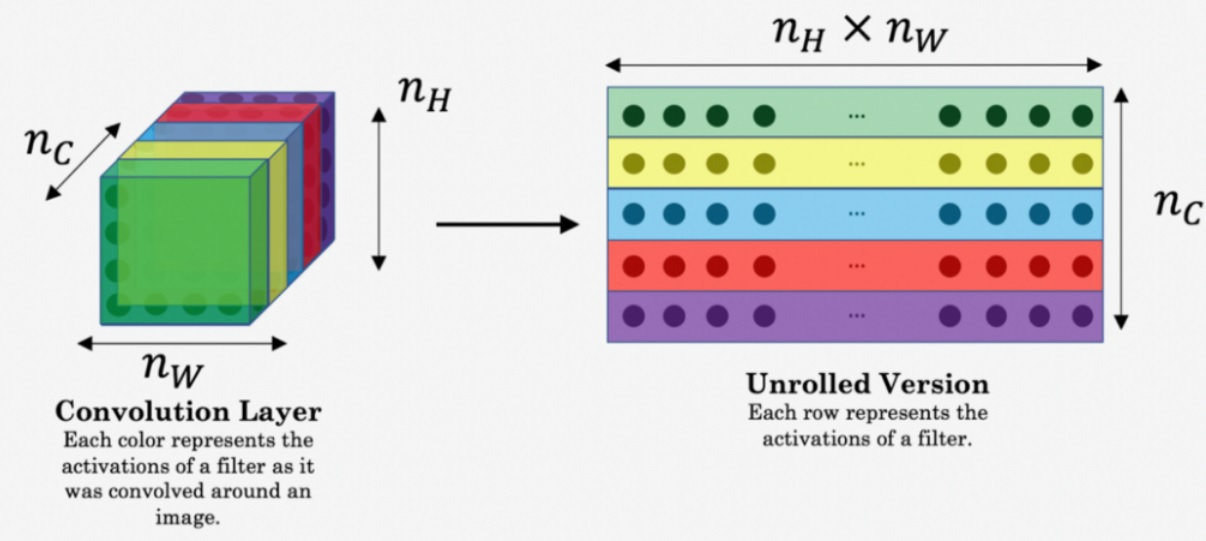


Finalmente con K.dot(features, K.transpose(features)) calculamos el producto punto de ambas matrices y obtenemos la matriz de Gram.

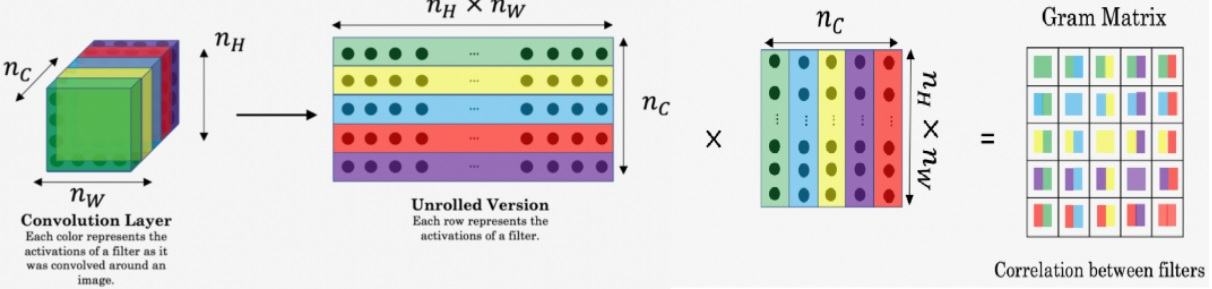


In [12]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

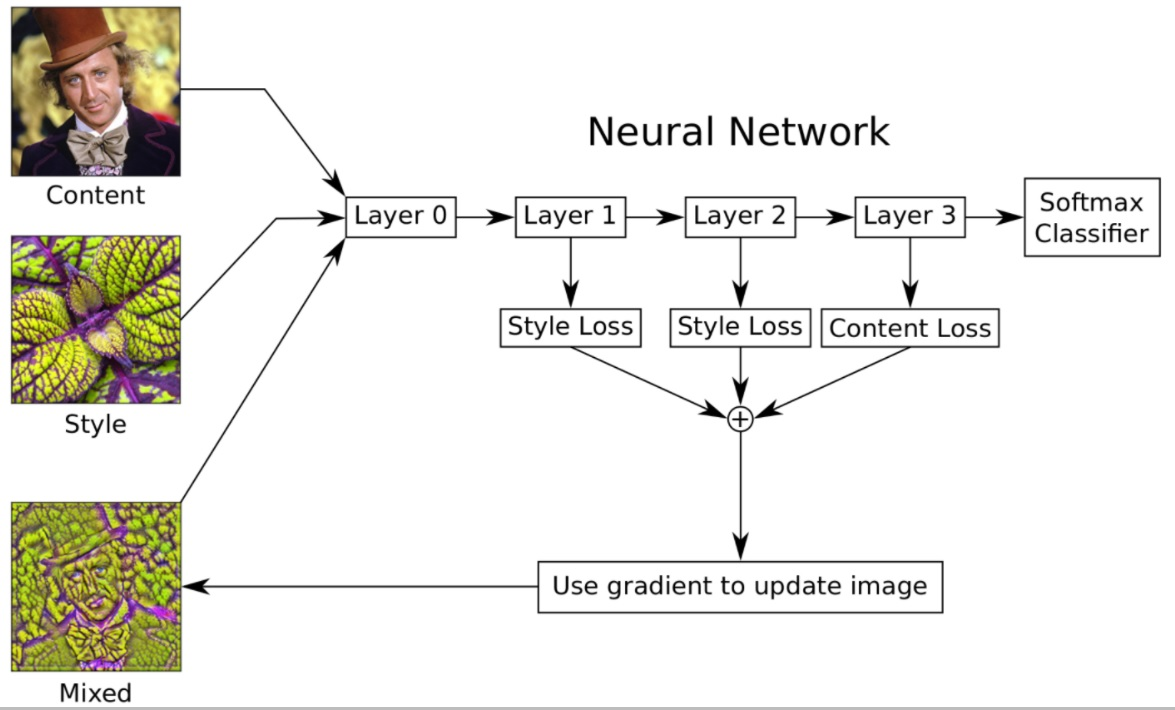

Podemos visualizar la información en diferentes etapas de procesamiento de la CNN mediante la reconstrucción de la imagen de entrada a partir de solo conocer las respuestas de la red en una capa en particular.

Las capas superiores (menos profundas) de la red capturan el contenido de alto nivel en términos de objetos y su disposición en la imagen de entrada, pero no contienen los valores exactos de píxeles de la reconstrucción.

Por el contrario, las reconstrucciones de las capas inferiores (mas profundas) reproducen los valores de píxeles exactos de la imagen original.


Rta:

## Style Loss:

La funcion de perdida de estilo esta para garantizar que el estilo presente en la imagen de estilo se encuentre representado en la imagen que estamos generando.

Entonces, como aqui estamos comparando el estilo de dos imagenes y queremos que se mantenga el estilo de la imagen de estilo tanto como sea posible, lo que necesitamos encontrar es la diferencias entre las matrices de Gram de ambas imagenes.

Por lo tanto, podemos definir la perdida de estilo como la raiz cuadrada de la diferencia cuadratica media entre ambas matrices de estilo, por lo que podemos concluir que la "informacion" del estilo se mide como la cantidad de correlacion presente entre los mapas de caracteristicas en una capa determinada de la red por lo que su perdida o loss esta definida como la diferencia de correlacion entre los mapas de caracteristicas calculados por la imagen generada y por la imagen de estilo y para ello es la matriz de Gram la herramienta que utilizaremos para encontrar estas correlaciones entre los mapas de caracteristicas de una capa de la red.


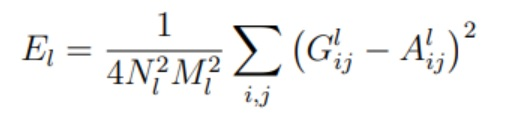




## Content Loss:

La funcion de contenido esta para garantizar que el contenido de la imagan de contenido se encuentre representado en la imagen que estamos generando.

La loss de contenido calcula la distancia euclideana entre las matrices de Gram de los mapas de caracteristicas de la imagen de contenido y la imagen que estamos generando.

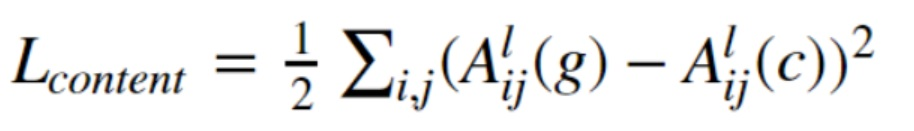



## Total variation loss:

Esta funcion garantiza la continuidad espacial y suavidad de la imagen generada evitando resultados ruidosos y excesivamente pixelados. Esto se logra encontrando las diferencias entre los pixels vecinos lo cual ayuda a mantener la imagen generada localmente coherente y podria ser interpretado como una especie de regularizacion.



In [13]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [14]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [15]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [16]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [17]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta:

## 6.1. Qué hace la función fmin_l_bfgs_b?

scipy.optimize.fmin_l_bfgs_b

scipy.optimize.fmin_l_bfgs_b(func, x0, fprime=None, args=(), approx_grad=0, bounds=None, m=10, factr=10000000.0, pgtol=1e-05, epsilon=1e-08, iprint=- 1, maxfun=15000, maxiter=15000, disp=None, callback=None, maxls=20)

Minimiza la funcion "func" utilizando el algoritmo L-BFGS-B.

Aqui se ejecuta el algoritmo de optimizacion L-BFGS sobre los pixels de la imagen generada con el fin de minimizar la funcion de perdida definida. Una particularidad de esta funcion es que debemos pasar como argumentos dos funciones, una que calcula la loss y otra funcion para el calculo de los gradientes.

En cada interaccion fmin_l_bfgs_b llamará a Evaluator.loss (x). Cada vez que se llama a Evaluator.loss (x), la entrada x alimenta a la red neuronal y termina dando un valor para la funcion de perdida, luego se calcula el gradiente a partir de esta pérdida.



## 6.2 ¿En qué se diferencia con la implementación del paper?

6.2.1. Diferencias en las capas utilizadas.

Las capas mensionadas en el papper son las siguientes:

content representation on layer: ‘conv4 2’.
style representations on layers: ‘conv1 1’, ‘conv2 1’, ‘conv3 1’, ‘conv4 1’ and ‘conv5 1’.


Las cuales son diferentes de las utilizadas en esta notebook:

layer_features: 'block5_conv2'
feature_layers: 'block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', block5_conv1'


Aqui la diferencia es la capa utilizada para el calculo de la loss de contenido, en el papper se mensiona la 'conv4_2' y en la notebook utilizamos la 'block5_conv2'.


6.2.2. La loss propuesta en esta notebook posee un termino mas "total_variation_loss" la cual posee un efecto regularizador.


6.2.3. En el papper se reemplazo el uso de "max pooling" por "average pooling" dado que notaron que esto mejora el flujo del gradiente y se obtienen resultados mas atractivos.


## 6.3. Se puede utilizar alguna alternativa?

En la solucion propuesta se utiliza el optimizagor L-BFGS (funcion "fmin_l_bfgs_b"), pero podriamos utilizar algun otro optimizador como ADAM o SGD.

Tambien entiendo que podriamo utilizar otro tipo de red neuronal pre entrenada y estudiar los resulados.


In [18]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [19]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [20]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Dimension en process image:  (1, 400, 320, 3)
Start of iteration 0
Current loss value: 14424729000.0
Image saved as /content/output/output_at_iteration_0.png
Iteration 0 completed in 18s
Start of iteration 1
Current loss value: 6884894000.0
Image saved as /content/output/output_at_iteration_1.png
Iteration 1 completed in 9s
Start of iteration 2
Current loss value: 4745292000.0
Image saved as /content/output/output_at_iteration_2.png
Iteration 2 completed in 9s
Start of iteration 3
Current loss value: 3902534700.0
Image saved as /content/output/output_at_iteration_3.png
Iteration 3 completed in 9s
Start of iteration 4
Current loss value: 3317751300.0
Image saved as /content/output/output_at_iteration_4.png
Iteration 4 completed in 9s
Start of iteration 5
Current loss value: 2813042700.0
Image saved as /content/output/output_at_iteration_5.png
Iteration 5 completed in 9s
Start of iteration 6
Current loss value: 2501356000.0
Image saved as /content/output/output_at_iteration_6.png
Iterati

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:
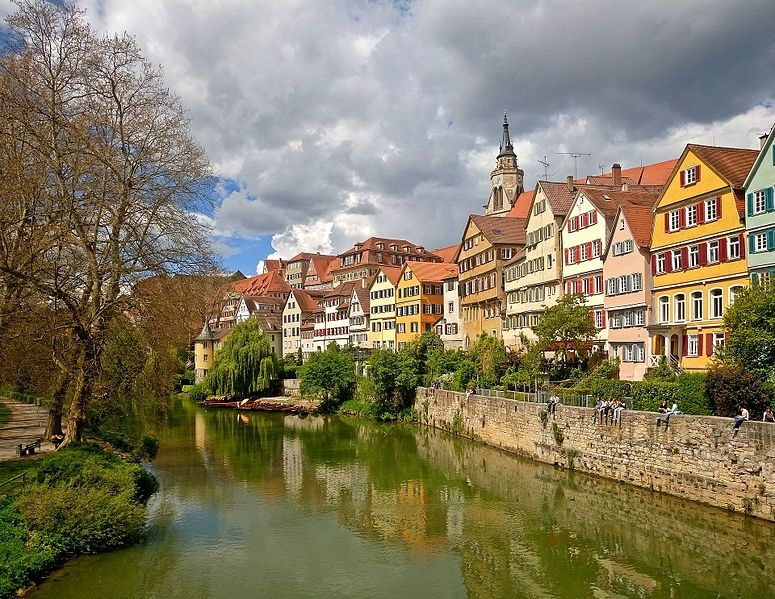
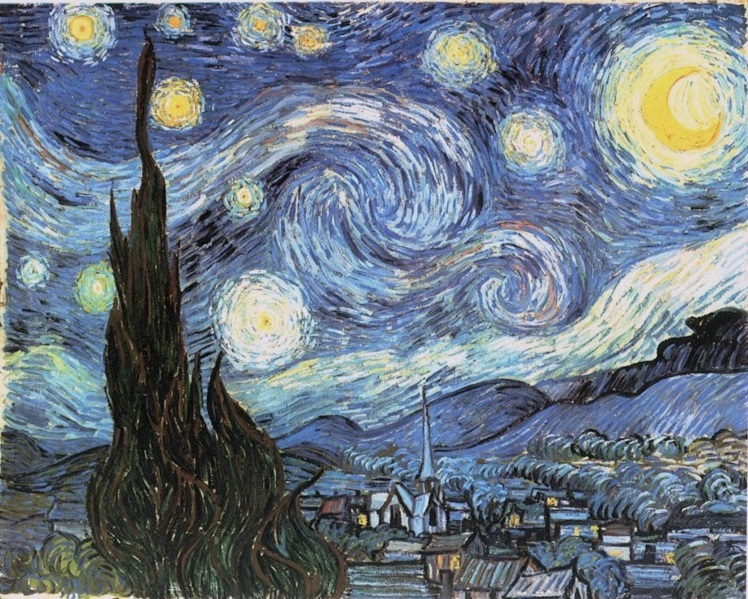
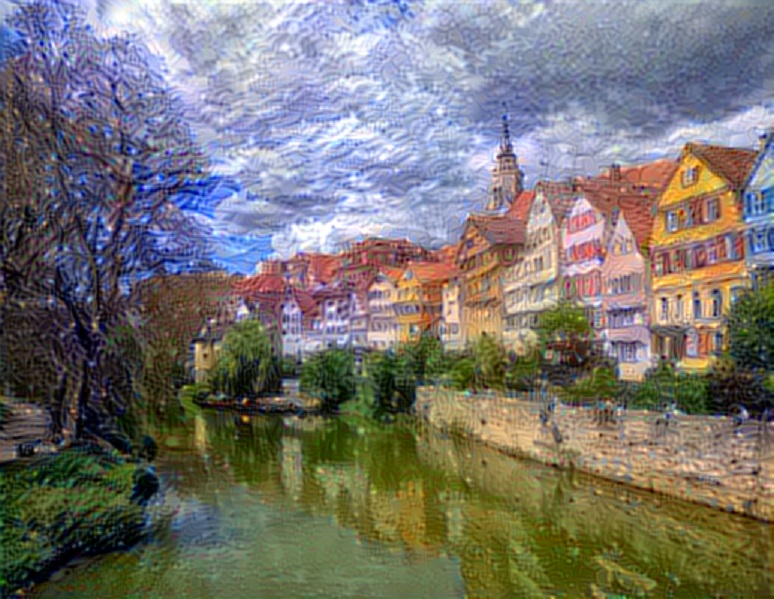

# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta:
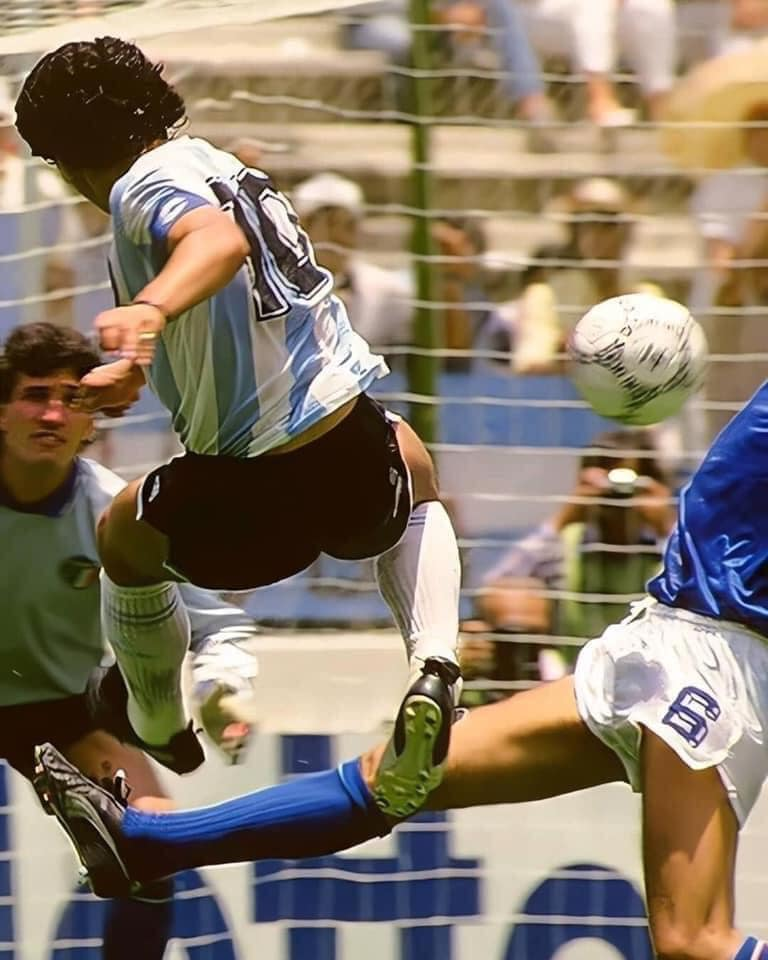
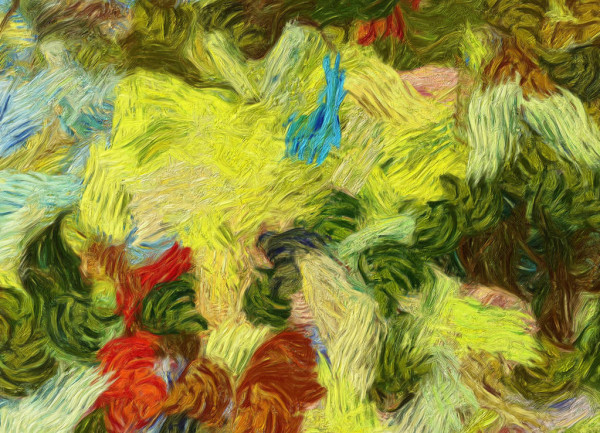
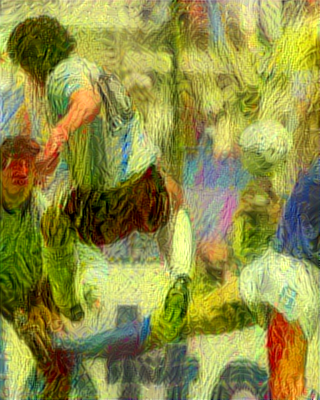